### Inference on the trained model ###

In [119]:
import sys
import os
import numpy as np
import json
import pandas as pd
import logging
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

logger = logging.getLogger(__name__)

# PyTorch
import torch

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh
from computervision.datasets import DETRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: True
Number of GPUs found:  1
Current device ID: 0
GPU device name:   NVIDIA GeForce RTX 3060 Laptop GPU
PyTorch version:   2.8.0a0+34c6371d24.nv25.08
CUDA version:      13.0
CUDNN version:     91200
Device for model training/inference: cuda:0
Current device cuda:0


In [105]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey', offset_xy=(0, 0)):
    offset_xy = (10 + offset_xy[0], 100 + offset_xy[1])
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Test data ###

In [4]:
# HSDM DATA
image_dir = os.path.join(os.environ.get('DATA'), 'dataset_object_240921')
df_file_name = 'objectdata_240921_clean_ide.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
display(df.head(2))

file_col = 'multi_file'
pos_col = 'pos'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,multi_file,pos,box_score,bbox,PatientIDE,annotator_name,d1,d2,d3,d4,d5,d6,disease,quality,single_file
0,457fecca_20180208_00.png,20,0.565375,"[0.0, 453.28, 267.08, 865.22]",457fecca,Maria,2,2,2,3,2,0,stable,yes,box_457fecca_20180208_00_00.png
1,8fb6f1a1_20220322_00.png,3,0.989590,"[0.0, 69.95, 501.94, 892.3]",8fb6f1a1,Maria,3,2,3,3,2,3,healthy,yes,box_8fb6f1a1_20220322_00_02.png


In [145]:
# Dentex testing data
image_dir = os.path.join(os.environ.get('DATA'), 'dentex_detection_250928', 'test')
df_file_name = 'train_quadrant_enumeration_test_set.parquet'
df_file = os.path.join(image_dir, df_file_name)
df = pd.read_parquet(df_file)
df = df.loc[(df['dset'] == 'test') & (df['transformation'] == 2)]
display(df.head(2))

file_col = 'file_name'
pos_col = 'ada'
bbox_col = 'bbox'

file_name_list = sorted(list(df[file_col].unique()))
file_list = [os.path.join(image_dir, file) for file in file_name_list]
# Check the test data
checked = [is_image(file) for file in file_list]
assert np.sum(checked) == len(file_list)

,bbox,quadrant,ada,file_name,file_base_name,quadrants,height,width,transformation,transformation_name,dset
11230,"[589, 0, 45, 306]",1.0,8.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test
11231,"[527, 0, 91, 306]",1.0,7.0,test_train_219_01_02.png,train_219,1,635,306,2,test_set,test


### Model and image processor ###

In [142]:
model_name = 'rtdetr_251001_02'
model_dir = os.path.join(os.environ.get('DATA'), 'model', model_name)
model_json_name = f'{model_name}.json'
model_json_file = os.path.join(model_dir, model_json_name)

checkpoint_name = 'checkpoint-17500'
checkpoint = os.path.join(model_dir, checkpoint_name)

# Load model parameters
with open(model_json_file, mode='r') as fl:
    model_parameters = json.load(fl)
display(model_parameters.keys())

# Category ID to label conversion
id2label = model_parameters.get('id2label')
id2label = {int(k): int(v) for k,v in id2label.items()}

# Load the image processor
processor = RTDetrImageProcessor.from_pretrained(checkpoint)
# Load the model
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint).to(device)

dict_keys(['model_info', 'id2label', 'training_args', 'processor_params', 'bbox_format'])

### Predict on an image ###

In [141]:
def predict_bboxes(model, processor, image, threshold):
    assert len(im.shape) == 3, 'Need RGB image as input'
    im_width, im_height = im.shape[1], im.shape[0]
    x_lim, y_lim = (0, im_width), (0, im_height)
    im_input = processor(im, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**im_input)
    output = processor.post_process_object_detection(model_output, 
                                                     target_sizes=torch.tensor([(im_height, im_width)]),
                                                     threshold=threshold)
    output_boxes = output[0].get('boxes').cpu().numpy()
    output_df = pd.DataFrame()
    if len(output_boxes) > 0:
        bboxes = [clipxywh(xyxy2xywh(list(box)), xlim=x_lim, ylim=y_lim, decimals=0) for box in output_boxes]
        categories = list(output[0].get('labels').cpu().numpy())
        scores = output[0].get('scores').cpu().numpy()
        categories = [int(c) for c in categories]
        scores = [np.around(s, decimals=4) for s in scores]
        output_dict = {'bboxes': bboxes, 'categories': categories, 'scores': scores}
        output_df = pd.DataFrame(output_dict)
        # Keep only one bounding box per category
        output_df = output_df.\
            sort_values(by=['categories', 'scores'], ascending=False).\
            groupby(by='categories').\
            first().\
            reset_index(drop=False).\
            sort_values(by='categories', ascending=True).\
            reset_index(drop=True)
    else:
        logger.warning(f'No predictions for input image at threshold {threshold}!')
    return output_df

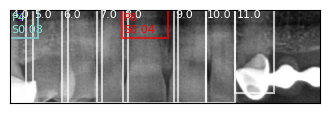

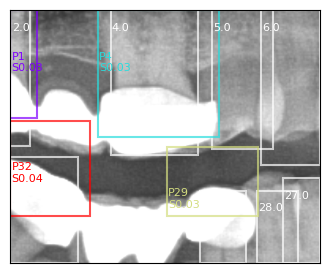

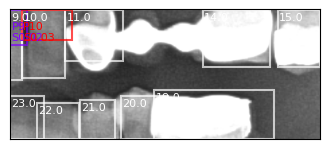

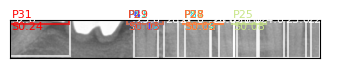

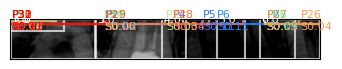

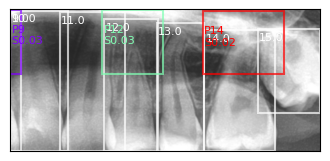

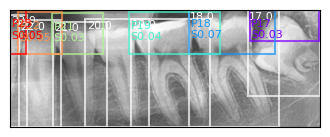

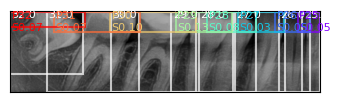

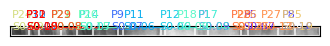

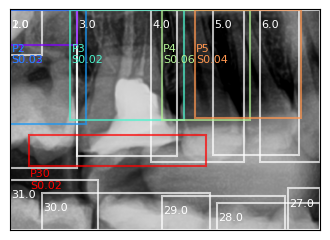

In [146]:
figsize = (4, 4)
threshold = 0.02

for idx, file_name in enumerate(file_name_list[20:30]):
    
    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    im = ImageData().np2color(im)
    df_file = df.loc[df[file_col] == file_name]
    bbox_list = df_file[bbox_col].tolist()
    pos_list = df_file[pos_col].tolist()
    im_width, im_height = im.shape[1], im.shape[0]
    x_lim, y_lim = (0, im_width), (0, im_height)
    
    # Predict positions
    output_df = predict_bboxes(model=model, processor=processor, image=im, threshold=threshold)
    if len(output_df) > 0:
        output_bbox_list = output_df['bboxes'].tolist()
        output_cat_list = output_df['categories'].tolist()
        output_pos_list = [id2label.get(cat) for cat in output_cat_list]
        score_list = output_df['scores'].tolist()
        output_pos_list = [f'P{p}\nS{s:.2f}' for p, s in zip(output_pos_list, score_list)]
    
        fig, ax = plt.subplots(figsize=figsize)
        ax = plot_boxes(image=im, box_list=bbox_list, label_list=pos_list, color='w', ax=ax)
        ax = plot_boxes(image=im, box_list=output_bbox_list, label_list=output_pos_list, ax=ax, offset_xy=(0, 200))
        plt.show()
    